In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.utils import show_prompt
from src.prompt import decision_to_route_inbound_logistics_tasks
show_prompt(decision_to_route_inbound_logistics_tasks, "decision_to_route_inbound_logistics_tasks")

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭─────────────────────────────────── decision_to_route_inbound_logistics_tasks ───────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the inbound logistics Data received so far:                                                          │
│  <Data>                                                                                                         │
│  {message}                                                                                                      │
│  </Data>                                                                                                        │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Your role is to act as the Supervisor Agent in the Inbound Logistics system.                                   │
│  Your responsibilities are:                                                                                     │
│  1. Assess the data provided by the user.                                                                       │
│  2. Decide whether the task should be delegated to:                                                             │
│     - `logistician_agent` → if the request relates to AWB# or AWB Date.                                         │
│     - `clearance_agent` → if the request relates to ATA or Clearance Date.                                      │
│  3. If the request is ambiguous or missing critical details, ask the user a **clarifying question** before      │
│  assigning the task.                                                                                            │
│                                                                                                                 │
│  Guidelines for asking clarification:                                                                           │
│  - Only ask if **absolutely necessary** (e.g., AWB#).                                                           │
│  - Keep questions **concise and structured**. Use bullet points or lists if multiple clarifications are         │
│  needed.                                                                                                        │
│  - Do not repeat questions if the information is already provided.                                              │
│                                                                                                                 │
│  Respond in **valid JSON format** with these exact keys:                                                        │
│  - `"question"`: "<clarifying question used with <delegate_to=clarify_with_user> if necessary information is    │
│  needed, otherwise empty>"                                                                                      │
│  - `"delegate_to"`: "logistician_agent" | "clearance_agent" | "supervisor_tools" | "clarify_with_user"          │
│  - `"agent_brief"`: "<acknowledgement message briefing the task sent to the chosen agent, confirming the        │
│  assignment>"                                                                                                   │
│                                                                                                                 │
│  Behavior:                                                                                                      │
│  - If clarification is needed → return:                                                                         │
│    - `"question": "<your clarifying question>"`       

In [4]:
%%writefile ../src/data_structure.py

"""State Definitions and Pydantic Schemas for Routing Workflow.

This defines the state objects and structured schemas used for
Routing to sub agent sworkflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from enum import Enum

# ===== STRUCTURED OUTPUT SCHEMAS =====

class NextAgent(str, Enum):
    END = "__end__"
    LOGISTICIAN_AGENT = "logistician_agent"
    CLEARANCE_AGENT  = "clearance_agent"
    supervisor_tools_AGENT = "supervisor_tools"
    
class ClarifyWithUser(BaseModel):
    """Schema for delegation decision and questions."""
    question: str = Field(
        description = "A question to ask the user to clarify the report scope",
    )
    delegate_to: NextAgent = Field(
        description = "A decision to delegate and route the task to the next agent",
    )
    agent_brief: str = Field(
        description = "A Brief that will be used to route the task to the next sub-agent",
    )
    
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for routing coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """
    
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    agent_brief: str
    full_schema: Optional[ClarifyWithUser] = None

Overwriting ../src/data_structure.py


In [5]:
%%writefile ../src/state_delegate.py

"""User Clarification and Routimg to Sub Agents.

This module implements the scoping phase of the Routing workflow, where we:
1. Assess if the user's data needs clarification
2. Delegate and route to Sub Agents

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with Routing.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage , get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver

from src.prompt import decision_to_route_inbound_logistics_tasks
from src.data_structure import AgentState, ClarifyWithUser, AgentInputState, NextAgent

checkpointer = InMemorySaver()
# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# ===== CONFIGURATION =====

# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
tools = []
tools_by_name = {tool.name: tool for tool in tools}

# ===== WORKFLOW NODES =====

def supervisor_agent(state: AgentState):
    """
    Determine if the user's request contains sufficient information to proceed.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either next agent or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=decision_to_route_inbound_logistics_tasks.format(
            message=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    return {
        "full_schema": response,
        "agent_brief": response.agent_brief,
        "supervisor_messages": [
            AIMessage(content=response.delegate_to.value)
        ]
    }

def clarify_with_user(state: AgentState):
    """In Case the user needs to be asked a clarifying question."""
    full_schema = state.get("full_schema")
    if full_schema and full_schema.question:
        question = full_schema.question
    return {"messages": [AIMessage(content=question)]}

def supervisor_tools(state: AgentState):
    """Executes all tool calls from the previous LLM responses.
       Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

def delegate_next_agent(state: AgentState) -> Literal["logistician_agent", "clearance_agent", "supervisor_tools", "clarify_with_user"]:
    """Determine where the control should move next.
    
    Determines whether the agent should execute the tools,  or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node"  : Continue to tool execution
        "next agent" : Stop and compress research"""

    # Then check the routing decision
    full_schema = state.get("full_schema")
    if not full_schema:
        return "__end__"

    if full_schema.delegate_to == NextAgent.LOGISTICIAN_AGENT:
        return "logistician_agent"
    elif full_schema.delegate_to == NextAgent.CLEARANCE_AGENT:
        return "clearance_agent"
    elif full_schema.delegate_to == NextAgent.CLARIFY_WITH_USER:
        return "clarify_with_user"
    else:
        return "__end__"

def logistician_agent(state: AgentState):
    pass

def clearance_agent(state: AgentState):
    pass

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
supervisor_agent_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
supervisor_agent_builder.add_node("supervisor_agent", supervisor_agent)
supervisor_agent_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_agent_builder.add_node("clarify_with_user", clarify_with_user)
supervisor_agent_builder.add_node("logistician_agent", logistician_agent)
supervisor_agent_builder.add_node("clearance_agent", clearance_agent)

# Add workflow edges
supervisor_agent_builder.add_edge(START, "supervisor_agent")
supervisor_agent_builder.add_conditional_edges(
    "supervisor_agent",
    delegate_next_agent,
    {
        "supervisor_tools": "supervisor_tools", # execute tools,
        "clarify_with_user": "clarify_with_user", # Provide final answer
        "logistician_agent": "logistician_agent",
         "clearance_agent": "clearance_agent"
    },
)
supervisor_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
supervisor_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
SupervisorAgent = supervisor_agent_builder.compile()

Overwriting ../src/state_delegate.py


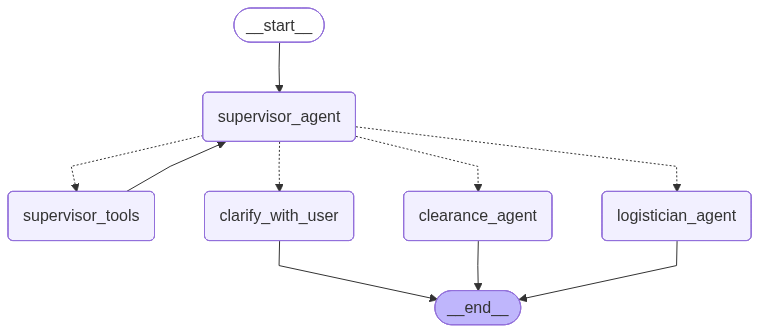

In [6]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from src.state_delegate import SupervisorAgent

display(Image(SupervisorAgent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
thread = {"configurable":{"thread_id":"1"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="I want to enter the AWB#")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB#', additional_kwargs={}, response_metadata={}, id='91f47fa3-9737-4c07-ba20-06611d36c8fc')],
 'supervisor_messages': [AIMessage(content='clearance_agent', additional_kwargs={}, response_metadata={}, id='0d6c930e-1e74-4eb4-a519-ab608c1552f2')],
 'agent_brief': '',
 'full_schema': ClarifyWithUser(question='Please provide the AWB# you wish to enter so we can proceed.', delegate_to=<NextAgent.CLEARANCE_AGENT: 'clearance_agent'>, agent_brief='')}

In [9]:
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Well the AWB# is 12334")]}, config=thread)
result

{'messages': [HumanMessage(content='Well the AWB# is 12334', additional_kwargs={}, response_metadata={}, id='6c6cdca9-df2e-446c-95a2-cf564f922aa1')],
 'supervisor_messages': [AIMessage(content='logistician_agent', additional_kwargs={}, response_metadata={}, id='a0570b62-061c-4bb4-b6e3-55688dea559b')],
 'agent_brief': 'Your request includes an AWB# (12334). I will assign this task to the Logistician Agent for further handling.',
 'full_schema': ClarifyWithUser(question='', delegate_to=<NextAgent.LOGISTICIAN_AGENT: 'logistician_agent'>, agent_brief='Your request includes an AWB# (12334). I will assign this task to the Logistician Agent for further handling.')}